In [ ]:
!git clone https://github.com/seantyh/morphert

Cloning into 'morphert'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 32 (delta 5), reused 30 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
!pip install -q --progress-bar off transformers umap-learn opencc hdbscan functorch
!pip install -U -q gensim





  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done






     |████████████████████████████████| 24.1 MB 11.0 MB/s 


In [ ]:
import sys
if "./morphert/src" not in sys.path:
  sys.path.append("./morphert/src")

In [ ]:
import pickle
from pathlib import Path
from itertools import groupby, combinations, permutations
from textwrap import wrap
from tqdm.auto import tqdm
from opencc import OpenCC

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from gensim.models import KeyedVectors

import torch
from functorch import jacrev, jacfwd
from transformers import BertTokenizer, BertModel, BertPreTrainedModel
from morphert.model import *

In [ ]:
N = 500000
base_dir = Path("/content/drive/MyDrive/LangOn/morphert")
t2s = OpenCC("t2s").convert
with open(base_dir/"tencent_small_500k.pkl", "rb") as fin:
    (vocabs, embs) = pickle.load(fin)   
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
model = MorphertModel.from_pretrained(base_dir/"morphert_500k")
collator_fn = DataCollator(tokenizer)
model = model.to("cuda")
full_ds = MorphertDataset(np.arange(N), vocabs, embs)
full_emb = np.vstack([full_ds[i]["vec"] for i in range(N)])
in_tencent = lambda x: x in full_ds.vocabs

Downloading:   0%|          | 0.00/107k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

In [ ]:
in_embeds = model.bert.embeddings.word_embeddings(torch.tensor([[101, 7442, 5582, 102]]).to("cuda"))
out_embeds = model(inputs_embeds=in_embeds)
out_tokens = model(**tokenizer("電腦", return_tensors="pt").to("cuda"))
torch.allclose(out_embeds.predictions, out_tokens.predictions)

True

In [ ]:
class TCKeyedVectorWrap:
  def __init__(self, kv, t2s):
    self.kv = kv
    self.t2s = t2s

  def __contains__(self, key):
    skey = self.t2s(key)
    return key in self.kv or skey in self.kv

  def __getitem__(self, key):
    skey = self.t2s(key)
    if key in self.kv:
      return self.kv[key]
    elif skey in self.kv:
      return self.kv[skey]
    else:
      raise KeyError("kv and its simp. not found")
tencent_kv = KeyedVectors(100)
tencent_kv.add_vectors(vocabs, embs)
tencent_kv_wrap = TCKeyedVectorWrap(tencent_kv, t2s)

In [ ]:
"一審" in tencent_kv_wrap, "一審" in tencent_kv

(True, False)

In [ ]:
def compute_token_jacobian_functorch(tgt_word, model, tokenizer):    
    tokens = tokenizer([tgt_word], return_tensors="pt").to("cuda")    
    in_embeds = model.bert.embeddings.word_embeddings(tokens.input_ids)
    def partial_effect(x):                     
        out = model(inputs_embeds=x)
        return out.predictions
    J = jacrev(partial_effect, argnums=0)(in_embeds)
    return J

## Load char-noise dataset

In [ ]:
import json
with open(base_dir / "affix_dataset.json", "r") as fin:
  affix_dataset = json.load(fin)

In [ ]:
item_x = affix_dataset["土"]

In [ ]:
item_x

[{'def': 'soil,earth,clay,land',
  'ex': [['土石', 50], ['土改', 28], ['土層', 16], ['土堤', 9], ['土壩', 6]]},
 {'def': 'local,native',
  'ex': [['土雞', 22], ['土狗', 17], ['土狼', 5], ['土豪', 5], ['土番', 2]]},
 {'def': 'soil,earth,clay,land',
  'ex': [['水土', 97], ['廢土', 55], ['黃土', 28], ['失土', 10], ['棄土', 8]]}]

In [ ]:
from itertools import chain
tgt_char = "方"
words = [x for x in vocabs[:50000] if len(x)==2 and x[0]!=x[1] and tgt_char in x][:10]
counters = set(x.replace(tgt_char, "") for x in words)
deriv_words = [x for x in vocabs[:50000] if len(x)==2 and x[0]!=x[1] and all((y in counters) for y in x)]
deriv_words
all_words = words + deriv_words

In [ ]:
all_words

['方面',
 '方式',
 '对方',
 '方法',
 '地方',
 '双方',
 '方向',
 '官方',
 '方便',
 '方案',
 '面对',
 '对面',
 '地面',
 '面向',
 '法官',
 '双向',
 '双面',
 '法案',
 '法式']

### Compute Jacobians for all targets and noise samples in the dataset

In [ ]:
def mark_target(x, pos):
  xlist = list(x)
  xlist[pos] = f"({x[pos]})"
  return "".join(xlist)

def compute_pairwise_distances(words, Js, tgt_pos):
  dists = np.zeros((len(words), len(words)))
  for a, b in combinations(words, 2):
      # L2norm = np.sqrt(((Js[a] - Js[b])**2).sum())            
      L1norm = np.abs(Js[a][:,tgt_pos,:] - Js[b][:,tgt_pos,:]).sum()
      idx_a = words.index(a)
      idx_b = words.index(b)
      dists[idx_a, idx_b] = dists[idx_b, idx_a] = L1norm      

  return dists

def compute_cross_distances(words, Js):
  # row is the canonical position
  # column is the counter position
  dists = np.zeros((len(words), len(words)))
  # compute self-cross
  for w in words:
      tgt_idx_a = 0
      tgt_idx_b = 1
      L1norm = np.abs(Js[w][:,tgt_idx_a,:] - Js[w][:,tgt_idx_b,:]).sum()
      idx_w = words.index(w)
      dists[idx_w, idx_w] = L1norm

  # compute dists across words
  for a, b in permutations(words, 2):
      # L2norm = np.sqrt(((Js[a] - Js[b])**2).sum())      
      tgt_idx_a = 0
      tgt_idx_b = 1
      L1norm = np.abs(Js[a][:,tgt_idx_a,:] - Js[b][:,tgt_idx_b,:]).sum()
      idx_a = words.index(a)
      idx_b = words.index(b)
      dists[idx_a, idx_b] = L1norm

  return dists

def compute_pairwise_emb_distances(words, embs):
  dists = np.zeros((len(words), len(words)))
  dists[:] = np.NaN
  for a, b in combinations(words, 2):
    if not (a in embs and b in embs): continue
    cossim = KeyedVectors.cosine_similarities(embs[a], [embs[b]])[0]
    idx_a = words.index(a)
    idx_b = words.index(b)
    dists[idx_a, idx_b] = dists[idx_b, idx_a] = 1-cossim
    dists[idx_a, idx_a] = dists[idx_b, idx_b] = 0.
  return dists

In [ ]:
import random
from itertools import chain

rng = random.Random(123)

# compute Jacobians for each word
J_buf = {}
for word in tqdm(all_words):
  if word in J_buf: continue
  J = compute_token_jacobian_functorch(word, model, tokenizer).squeeze().detach().cpu().numpy()
  # subset the second token (the first character, considering the [CLS] offset)
  J_buf[word] = J[:,1:3,:]

## predicted word embeddings
with torch.no_grad():    
  preds = model(**tokenizer(words, return_tensors="pt").to("cuda")).predictions.cpu().numpy()

J_target_dists = compute_pairwise_distances(all_words, J_buf, 0)
J_counter_dists = compute_pairwise_distances(all_words, J_buf, 1)
J_cross_dists = compute_cross_distances(all_words, J_buf)


  0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/autograd/__init__.py:277: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::infinitely_differentiable_gelu_backward. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /__w/functorch/functorch/functorch/csrc/BatchedFallback.cpp:85.)
  allow_unused, accumulate_grad=False)  # Calls into the C++ engine to run the backward pass


In [ ]:
N = len(all_words)
D = np.zeros((N*2, N*2))
D[:N, :N] = J_target_dists
D[N:, N:] = J_counter_dists
D[:N, N:] = J_cross_dists
D[N:, :N] = J_cross_dists.transpose()

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP(n_neighbors=10, metric="precomputed", transform_mode="graph")
G = reducer.fit_transform(D)
dG = G.todok()

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


In [ ]:
import graphviz
dot = graphviz.Graph('chareme', engine="sfdp")
dot.attr(size="10!", overlap="False", len="1")
dot.attr("edge", penwidth="1", color="gray")
dot.attr('node', shape="box", margin="0", width="0", height="0")
for i, w in enumerate(all_words):
  dot.node(str(i), mark_target(w, 0))
  dot.node(str(i+len(all_words)), mark_target(w, 1))

for k, v in dG.items():
  if v > 0. and k[0]>k[1]:    
    dot.edge(str(k[0]), str(k[1]), weight=str(v))

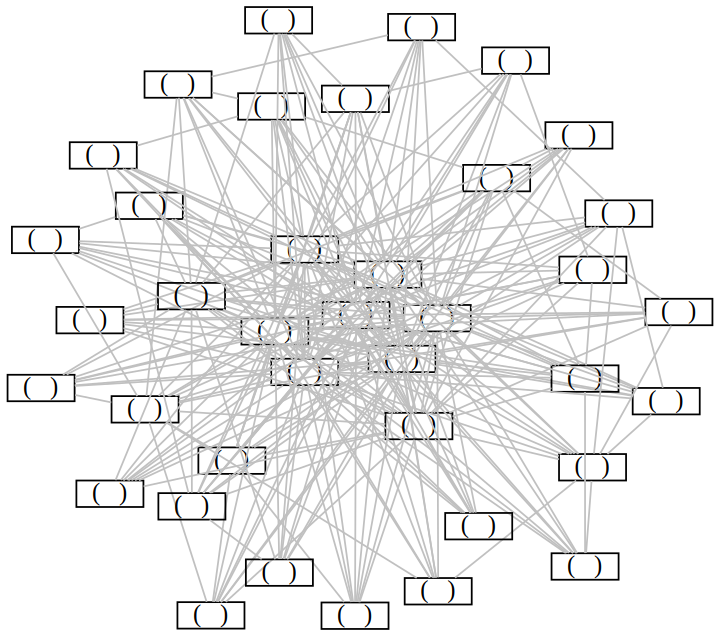

In [ ]:
dot